# Imports

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys


import xobjects as xo
import xtrack as xt
import xpart as xp

sys.path.append('../')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt


LINEFOLDER   = '../Data/Lines/'
SURVEYFOLDER = '../Data/Surveys/'
df_columns = ['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'mux', 'muy', 'qx', 'qy', 'qs', 'dqx', 'dqy']


line   = {}
twiss  = {}
survey = {}

# Importing survey
for seq in ['lhcb1','lhcb2']:
    _beam = seq[-2:]
    survey[_beam] = pd.read_pickle(SURVEYFOLDER + f'survey_opticsfile32_{seq}.pkl')

# Importing twiss
for seq in ['lhcb1','lhcb4']:
    _beam = seq[-2:]
    
    # Importing Line
    line[_beam] = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')
    
    # Importing twiss and tracker
    if _beam == 'b1':
        tracker = xt.Tracker(line=line[_beam])
        xtwiss  = tracker.twiss()
    else:
        xtwiss  = xt.Tracker(line=line[_beam]).twiss()
    
    twiss[_beam]= pd.DataFrame(xtwiss,columns = df_columns)
    twiss[_beam].set_index('name',inplace=True)


# Creating twiss b2 from b4
#==========================================
twiss['b2'] = xPlus.twiss_b2_from_b4(twiss['b4'])


# Filtering twiss
#====================================
twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
#====================================

# Clearing xsuite ouput
clear_output(wait=False)






# Creating IP objects!

In [3]:
B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)

--- 

# Beam-beam separation

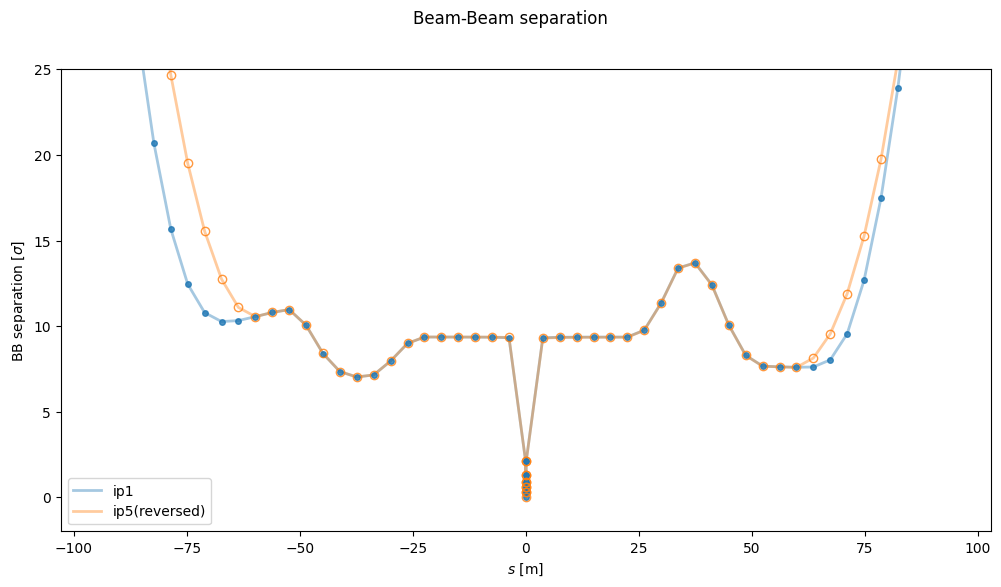

In [4]:
fig = plt.figure(figsize=(12,6))
fig.suptitle(f'Beam-Beam separation')

for _IP in [IP1,IP5]:
    
    # Plotting   
   
    dx_n_tot = np.sqrt(_IP.bb['dx_n']**2 + _IP.bb['dy_n']**2)
    if _IP.name == 'ip1':
        plt.plot(_IP.bb['s'],dx_n_tot,'-',color='C0',alpha=0.4,lw=2,label=_IP.name,zorder=-10)
        plt.plot(_IP.bb['s'],dx_n_tot,ls='' ,color='C0',alpha=0.8,marker='.',ms=8)
    else:
        plt.plot(-_IP.bb['s'],dx_n_tot,'-',color='C1',alpha=0.4,lw=2,label=_IP.name + '(reversed)',zorder=-9)
        plt.plot(-_IP.bb['s'],dx_n_tot,ls='' ,color='C1',alpha=0.8,marker='.',mfc='none',ms=12)
    plt.legend()
    
    plt.xlabel(r'$s$ [m]')
    plt.ylabel(r'BB separation [$\sigma$]')
    
    plt.ylim([-2,25])

# Plotting full octupolar footprint

Execution time, HO: 0.109 s
Execution time, LR: 0.379 s
Execution time, HO: 0.084 s
Execution time, LR: 0.458 s


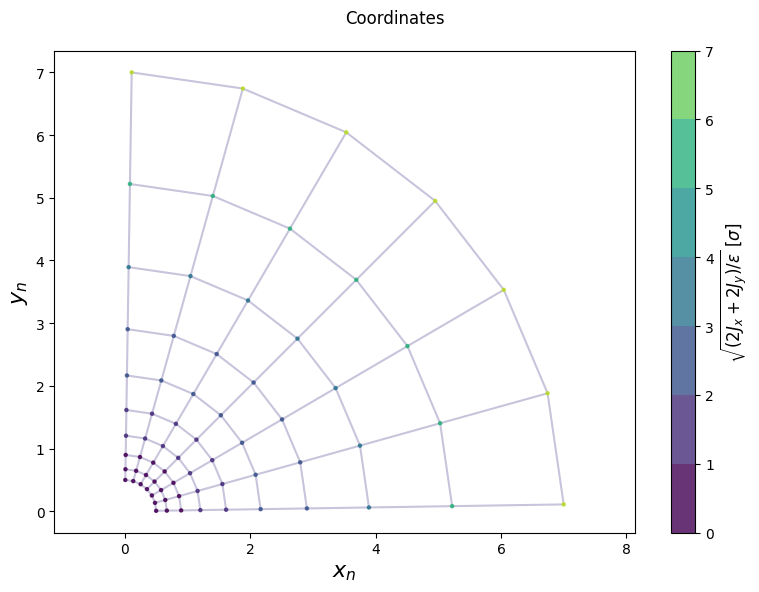

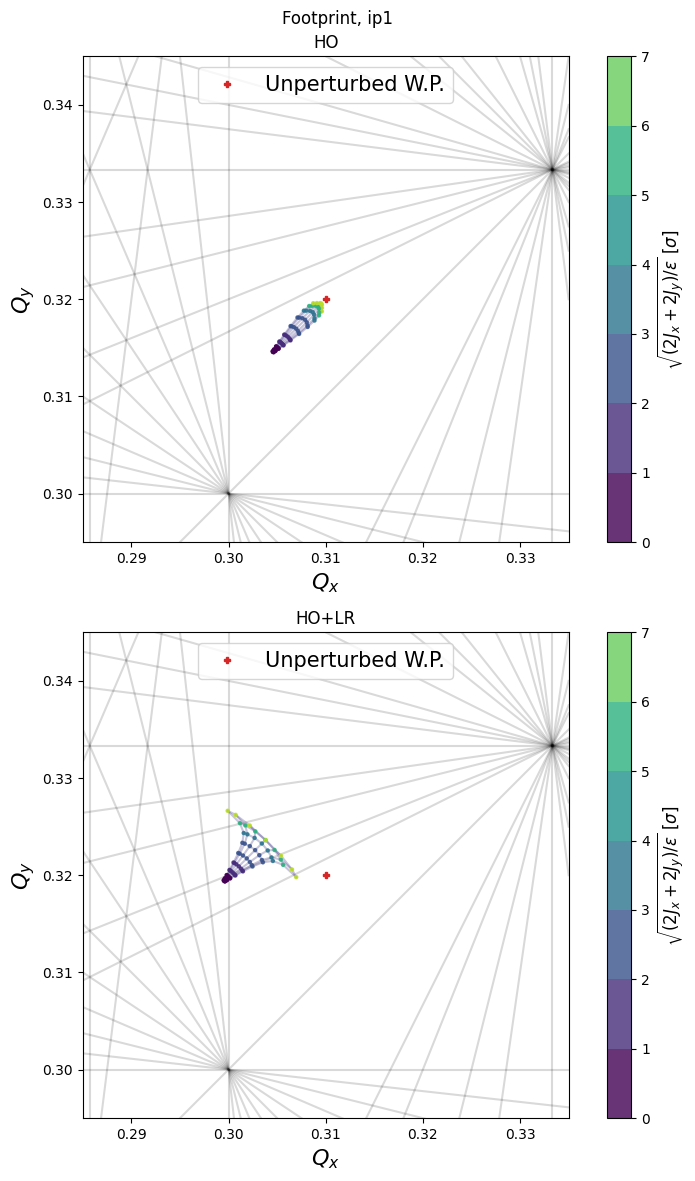

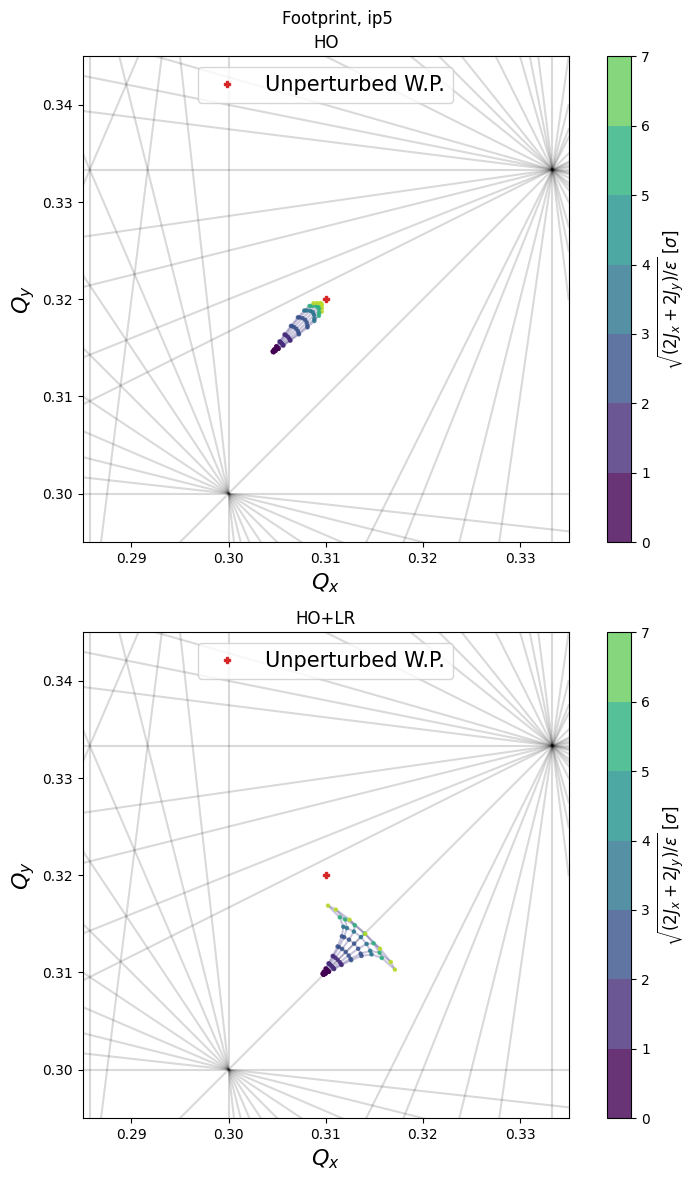

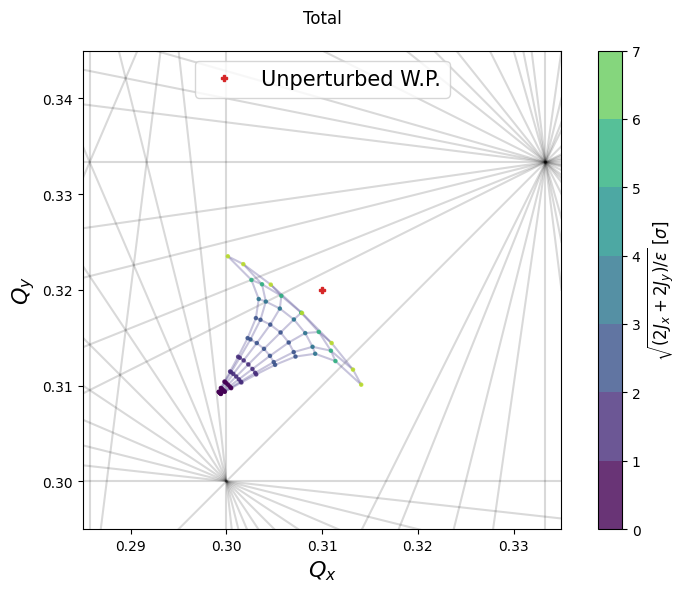

In [7]:
import time

# Generating Coord grid
#=========================================================
coordinates = phys.polar_grid(  r_n     = np.logspace(np.log10(0.5),np.log10(7),10),
                                theta_n = np.linspace(0.01*np.pi/2,0.99*np.pi/2,7),
                                emitt   = [B1.emittx,B1.emitty])


# Plotting coordinates
#-----------------------
plt.figure(figsize=(8,6))
cmap = 'viridis'
cmax = int(np.max(coordinates['r_n'])+1)
boundaries = np.linspace(0,cmax,cmax+1)

plt.suptitle('Coordinates')

bbplt.polarmesh(coordinates['x_n'],coordinates['y_n'],r=coordinates['r_n'],theta=coordinates['theta_n'],color='darkslateblue')
bbplt.boundedScatter(coordinates['x_n'],coordinates['y_n'],c=coordinates['r_n'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')

plt.xlabel(r'$x_n$',fontsize=16);
plt.ylabel(r'$y_n$',fontsize=16);
plt.axis('square');
cbar = plt.colorbar()
plt.set_cmap(cmap)
cbar.ax.set_ylim([0,np.max(coordinates['r_n'])])
cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
plt.tight_layout()
#=========================================================


Qx_0,Qy_0 = 0.31,0.32
window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

DQx_total,DQy_total = np.zeros(len(coordinates)),np.zeros(len(coordinates))
for IP in [IP1,IP5]:
    DQx_IP,DQy_IP = np.zeros(len(coordinates)),np.zeros(len(coordinates))
    
    # Generic HO
    _bb = IP.ho.loc[IP.ho.index[len(IP.ho)//2]]

    s_time = time.time()
    _DQx,_DQy = dtune.HeadOn_round(   ax    = coordinates['x_n'],
                                    ay    = coordinates['y_n'],
                                    r     = _bb['r'],
                                    emitt = IP.b2.emittx,
                                    xi    = IP.b2.xi)

    DQx_total += _DQx
    DQy_total += _DQy
    DQx_IP    += _DQx
    DQy_IP    += _DQy
    e_time = time.time()
    print(f'Execution time, HO: {(e_time-s_time):.3f} s')

    
    fig,axes = plt.subplots(2,1,figsize=(8,12))
    fig.suptitle(f'Footprint, {IP.name}')

    # Plotting HO only
    #-----------------------
    plt.sca(axes[0])
    plt.gca().set_title('HO')

    def plot_IP_tune():
        bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=10,color='k',alpha=0.15)
        bbplt.polarmesh(Qx_0 + DQx_IP,Qy_0 + DQy_IP,r=coordinates['r_n'],theta=coordinates['theta_n'],color='darkslateblue')
        bbplt.boundedScatter(Qx_0 + DQx_IP,Qy_0 + DQy_IP,c=coordinates['r_n'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')
        plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

        plt.legend(fontsize=15)
        plt.xlabel(r'$Q_x$',fontsize=16);
        plt.ylabel(r'$Q_y$',fontsize=16);
        plt.axis('square');
        cbar = plt.colorbar()
        plt.set_cmap(cmap)
        cbar.ax.set_ylim([0,np.max(coordinates['r_n'])])
        cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
        plt.xlim(Qx_lim)
        plt.ylim(Qy_lim)
    plot_IP_tune()


    # Generic LR
    s_time = time.time()
    for index, _bb in IP.lr.iterrows():
        _DQx,_DQy = dtune.BBLR_octupole(    coordinates['J_x'],
                                            coordinates['J_y'],
                                            betx = _bb['betx'],
                                            bety = _bb['bety'],
                                            k1   = _bb['k1'],
                                            k3   = _bb['k3'])
        DQx_total += _DQx
        DQy_total += _DQy
        DQx_IP    += _DQx
        DQy_IP    += _DQy
    e_time = time.time()
    print(f'Execution time, LR: {(e_time-s_time):.3f} s')

    plt.sca(axes[1])
    plt.gca().set_title('HO+LR')
    plot_IP_tune()

    plt.tight_layout()



plt.figure(figsize=(8,6))
plt.suptitle(f'Total')

bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=10,color='k',alpha=0.15)
bbplt.polarmesh(Qx_0 + DQx_total,Qy_0 + DQy_total,r=coordinates['r_n'],theta=coordinates['theta_n'],color='darkslateblue')
bbplt.boundedScatter(Qx_0 + DQx_total,Qy_0 + DQy_total,c=coordinates['r_n'],s=5,alpha=0.8,boundaries=boundaries,cmap='viridis')
plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

plt.legend(fontsize=15)
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
cbar = plt.colorbar()
plt.set_cmap(cmap)
cbar.ax.set_ylim([0,np.max(coordinates['r_n'])])
cbar.ax.set_ylabel(r'$\sqrt{(2J_x + 2J_y)/\varepsilon}$ [$\sigma$]',fontsize=12)
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()





# More on the working diagram

In [24]:
import BBStudies.Physics.Resonances as resn

resn.resonance_df(order=12).head(10)

,ID,Order,slope,y0,x0
0,"(-11, 1, 0, 1)",12,-11.000000,0.0,NaN
1,"(11, 1, 0, 1)",12,11.000000,0.0,NaN
2,"(-1, 11, 0, 1)",12,-0.090909,0.0,NaN
3,"(1, 11, 0, 1)",12,0.090909,-0.0,NaN
4,"(1, 11, 1, 1)",12,0.090909,1.0,NaN
5,"(-1, 11, 1, 1)",12,-0.090909,1.0,NaN
6,"(-10, 1, 0, 1)",11,-10.000000,0.0,NaN
7,"(10, 1, 0, 1)",11,10.000000,0.0,NaN
8,"(-1, 10, 0, 1)",11,-0.100000,0.0,NaN
9,"(1, 10, 0, 1)",11,0.100000,-0.0,NaN


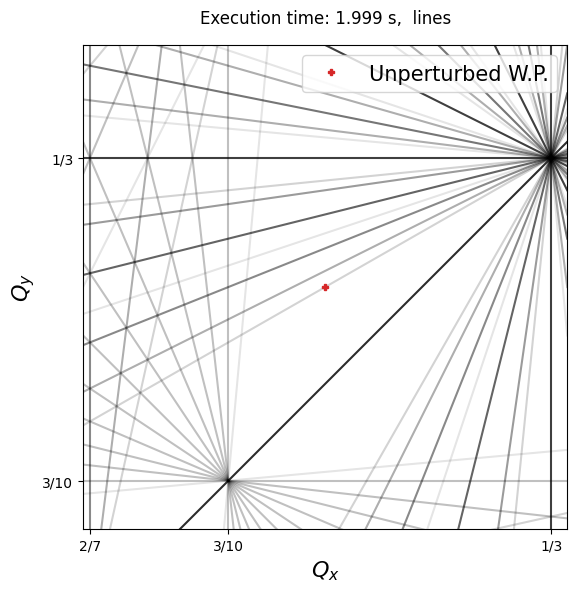

In [15]:

# Try different alpha values

ORDER = 12
orders = list(np.arange(ORDER)+1)
alphas = np.linspace(0.1,0.9,len(orders))[::-1]

Qx_0,Qy_0 = 0.31,0.32
window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure(figsize=(8,6))

s_time = time.time()
for order,alpha in zip(orders,alphas):
    bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=[order],color='k',alpha=alpha)
e_time = time.time()
plt.suptitle(f'Execution time: {(e_time-s_time):.3f} s,  lines')
plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
bbplt.xticks_from_farey(order=ORDER)
bbplt.yticks_from_farey(order=ORDER)
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()


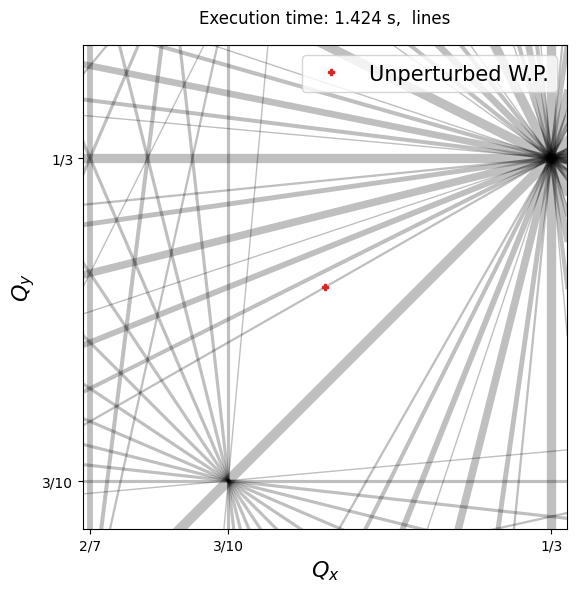

In [18]:

# Try different alpha values

ORDER = 12
orders = list(np.arange(ORDER)+1)[::-1]
lws    = np.linspace(1,8,len(orders))

Qx_0,Qy_0 = 0.31,0.32
window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure(figsize=(8,6))

s_time = time.time()
for order,lw in zip(orders,lws):
    bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=[order],color='k',lw=lw, alpha=0.25)
e_time = time.time()
plt.suptitle(f'Execution time: {(e_time-s_time):.3f} s,  lines')
plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
bbplt.xticks_from_farey(order=ORDER)
bbplt.yticks_from_farey(order=ORDER)
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()


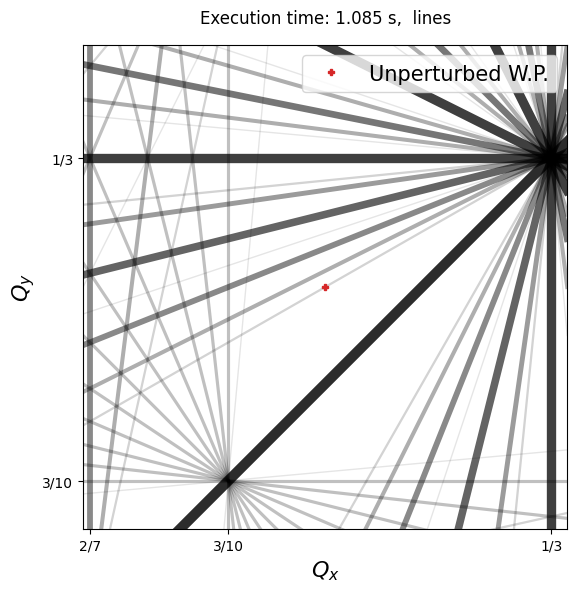

In [19]:

# Try different alpha values

ORDER = 12
orders = list(np.arange(ORDER)+1)[::-1]
lws    = np.linspace(1,8,len(orders))
alphas = np.linspace(0.1,0.9,len(orders))

Qx_0,Qy_0 = 0.31,0.32
window    = 0.05
Qx_lim    = [Qx_0-window/2,Qx_0+window/2]
Qy_lim    = [Qy_0-window/2,Qy_0+window/2]

plt.figure(figsize=(8,6))

s_time = time.time()
for order,lw,alpha in zip(orders,lws,alphas):
    bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=[order],color='k',lw=lw, alpha=alpha)
e_time = time.time()
plt.suptitle(f'Execution time: {(e_time-s_time):.3f} s,  lines')
plt.plot([Qx_0],[Qy_0],'P',markersize=5,color='C3',label='Unperturbed W.P.')

plt.legend(fontsize=15,loc='upper right')
plt.xlabel(r'$Q_x$',fontsize=16);
plt.ylabel(r'$Q_y$',fontsize=16);
plt.axis('square');
bbplt.xticks_from_farey(order=ORDER)
bbplt.yticks_from_farey(order=ORDER)
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()
